Creates a narrowed down list of wells that have yet to be tested, but are within a certain range of a well that has been tested. Per the results of flanagan et al (2020) targeteting wells that are within 1.5 km of a well that has shown elevated arsenic levels is a more efficient use of resources than targeting all wells in a larger area as seen on Gaston Water Map. While the water map outlines the broader area where elevated resutls are present, the clustering of arsenic appears to be much more localized within the outlined risk area.

In [ ]:
import geopandas as gpd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fiona as fio
import shapely as shp  

In [4]:
# Read in all wells, and sampled wells csv files

wells_all = pd.read_csv('../data/gis/point/all_wells.csv')
wells_ar = pd.read_csv('../data/gis/point/ar_samples.csv')

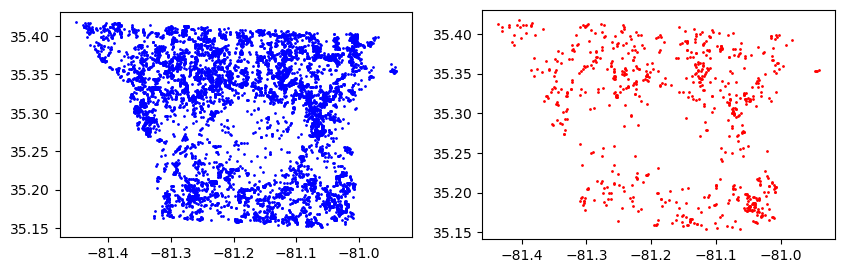

In [5]:
# convert to geodataframe

wells_all = gpd.GeoDataFrame(wells_all, geometry=gpd.points_from_xy(wells_all.X, wells_all.Y, crs='EPSG:4326'))
wells_ar = gpd.GeoDataFrame(wells_ar, geometry=gpd.points_from_xy(wells_ar.X, wells_ar.Y, crs='EPSG:4326'))

# plot the two geo dataframes in the same plot same row

fig, ax = plt.subplots(1,2, figsize=(10,5))
wells_all.plot(ax=ax[0], color='blue', markersize=1)
wells_ar.plot(ax=ax[1], color='red', markersize=1)
plt.show()

In [10]:
# convert both geodataframes to projected coordinate system for network analysis

wells_all = wells_all.to_crs('EPSG:32617')
wells_ar = wells_ar.to_crs('EPSG:32617')


In [11]:
# remove the wells that have been sampled from the all wells dataframe

wells_all = wells_all[~wells_all['id'].isin(wells_ar['id'])]
len(wells_all)

7419

In [24]:
# subset the sampled wells to only include wells that have elevated results

wells_elev = wells_ar[wells_ar['group'] == 1]

# create a new polygon layer from a 500 foot buffer around the elevated wells

elevated_buffer = wells_elev.buffer(500)




In [25]:
len(elevated_buffer)

35

In [ ]:

# crate a series the length of the buffer, and set all values to 1

val = pd.Series(np.ones(len(elevated_buffer)))

# convert the buffer to a polygon geo data frame

elevated_buffer = gpd.GeoDataFrame(val, geometry=elevated_buffer, crs='EPSG:32617')

elevated_buffer.head()

In [20]:
elevated_buffer

13     POLYGON ((478597.539 3907452.573, 478595.131 3...
61     POLYGON ((478219.804 3917663.451, 478217.396 3...
67     POLYGON ((478140.764 3917894.581, 478138.356 3...
72     POLYGON ((469322.686 3915112.959, 469320.279 3...
79     POLYGON ((474613.382 3914261.543, 474610.974 3...
122    POLYGON ((479857.257 3913817.979, 479854.850 3...
136    POLYGON ((475676.276 3918762.144, 475673.868 3...
179    POLYGON ((473704.303 3914898.606, 473701.896 3...
180    POLYGON ((476986.008 3915436.612, 476983.600 3...
182    POLYGON ((478593.059 3918337.758, 478590.652 3...
192    POLYGON ((474794.708 3914165.774, 474792.301 3...
226    POLYGON ((475554.018 3909893.229, 475551.611 3...
280    POLYGON ((478471.767 3918666.026, 478469.360 3...
312    POLYGON ((476851.190 3916308.894, 476848.782 3...
316    POLYGON ((478455.381 3915952.198, 478452.973 3...
346    POLYGON ((475921.509 3917093.368, 475919.102 3...
348    POLYGON ((474528.667 3913809.910, 474526.259 3...
362    POLYGON ((467253.709 390

In [18]:
# create a new column in the buffer dataframe that will be used to identify the wells that are within the buffer

elevated_buffer['elevated_nearby'] = 1

# join the wells to the buffer

wells_to_test = gpd.sjoin(wells_all, elevated_buffer, how='left', op='within')

# verify the join

wells_to_test.head()


TypeError: BaseGeometry.__new__() takes 1 positional argument but 2 were given

In [16]:
# create a list of all the addresses where the wells are within the buffer

addresses = wells_all[wells_all['within_buffer'] == 1]['address'].tolist()



Index(['id', 'full_add', 'year_built', 'date_tested', 'date_tested.1',
       'year_tested', 'X', 'Y', 'ar', 'group', 'group_five', 'depth', 'ph',
       'geometry'],
      dtype='object')

In [ ]:
# create a postcard template for each address in the list, and save it to a folder


for address in addresses:
    print(address)
    os.system('python ../src/postcard.py -a ' + address + ' -o ../data/postcards/')

